In [70]:
# ml-1m

In [71]:
# Apply fairness-aware data re-sampling (inspired by Ekstrand et al.) on ml-1m dataset for RecBole
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load user profile, label interactions and original atomic interactions
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')  # user_id:token, gender, age, etc.
inter_df_label = pd.read_csv('../datasets/split_datasets/ml-1m/ml-1m.train.inter', sep='\t')  # user_id:token, item_id:token, timestamp, label
inter_df_atomic = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.inter', sep='\t')  # user_id:token, item_id:token, rating, timestamp

# 2. Merge rating into train.inter
inter_df = inter_df_label.merge(
    inter_df_atomic[['user_id:token', 'item_id:token', 'rating:float']],
    how='left',
    left_on=['user_id:token', 'item_id:token'],
    right_on=['user_id:token', 'item_id:token']
)

# 3. Merge gender info
merged_df = inter_df.merge(
    user_df[['user_id:token', 'gender:token']],
    on='user_id:token',
    how='left'
)

merged_df.rename(columns={'gender:token': 'gender'}, inplace=True)

display(merged_df.head())

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,1791,3949,974700700.0,1.0,4,M
1,1791,1084,974702340.0,1.0,3,M
2,1791,1805,974761150.0,0.0,2,M
3,1791,3897,974701200.0,1.0,4,M
4,1791,3741,974702400.0,1.0,4,M


gender
M    606823
F    198620
Name: count, dtype: int64
gender
M    0.753403
F    0.246597
Name: proportion, dtype: float64


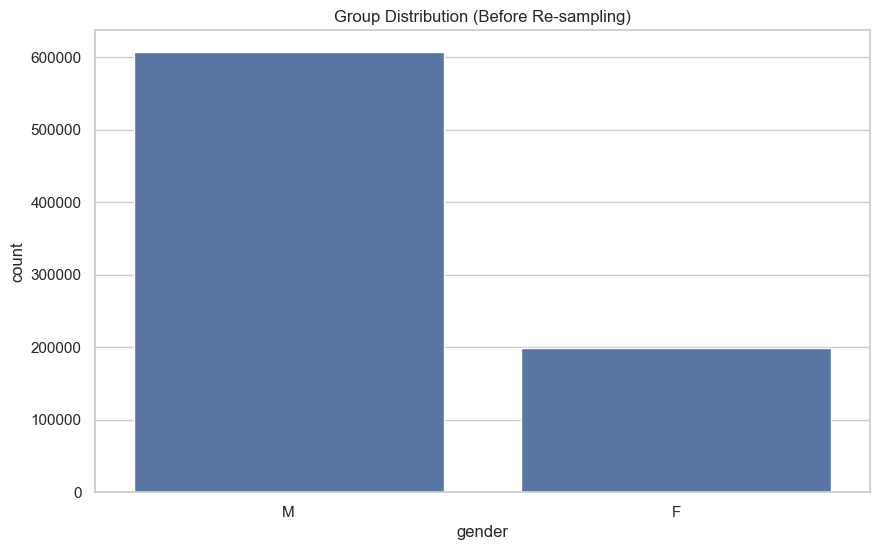

In [72]:
# 4. Check gender distribution
gender_counts = merged_df['gender'].value_counts()
print(gender_counts)
gender_dist = merged_df['gender'].value_counts(normalize=True)
print(gender_dist)
sns.countplot(data=merged_df, x='gender')
plt.title('Group Distribution (Before Re-sampling)')
plt.show()

In [73]:
# 5. Balance male/female interactions (downsample majority group)
female_df = merged_df[merged_df['gender'] == 'F']
male_df = merged_df[merged_df['gender'] == 'M']

target_size = len(female_df)
print(f"Female interactions: {target_size}")
print(f"Male interactions before: {len(male_df)}")

male_positive = male_df[male_df['label:float'] == 1]
male_negative = male_df[male_df['label:float'] == 0]
print(f"male_positive interactions: {len(male_positive)}")

male_sampled = male_positive.sample(n=target_size, random_state=42)

Female interactions: 198620
Male interactions before: 606823
male_positive interactions: 505428


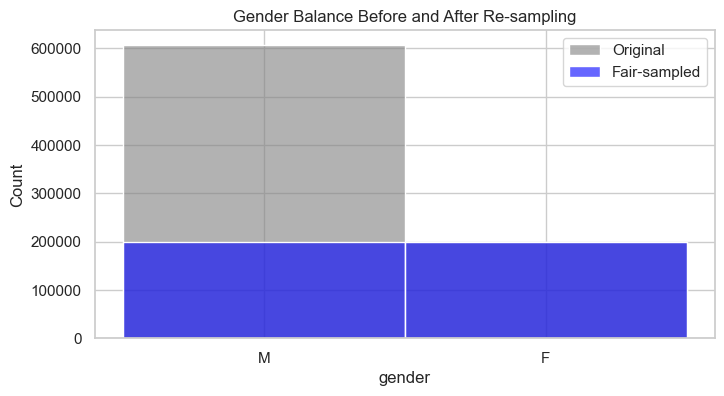

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,5474,32,9.598812e+08,1.0,4,M
1,2857,1333,9.725052e+08,1.0,4,M
2,571,1396,9.759983e+08,1.0,4,M
3,678,1918,9.892416e+08,1.0,3,M
4,1354,3686,9.754578e+08,1.0,4,F
...,...,...,...,...,...,...
397235,3125,151,1.004734e+09,1.0,4,M
397236,979,1581,9.912534e+08,1.0,4,M
397237,4329,21,9.652428e+08,1.0,4,F
397238,1516,1541,1.004648e+09,0.0,2,F


In [74]:
# Combine and shuffle balanced groups
df_fair = pd.concat([female_df, male_sampled], ignore_index=True)
df_fair = df_fair.sample(frac=1, random_state=42).reset_index(drop=True)


# 7. Optional: plot before and after
plt.figure(figsize=(8,4))
sns.histplot(data=merged_df, x="gender", stat="count", color="gray", label="Original", alpha=0.6)
sns.histplot(data=df_fair, x="gender", stat="count", color="blue", label="Fair-sampled", alpha=0.6)
plt.title("Gender Balance Before and After Re-sampling")
plt.legend()
plt.show()

display(df_fair)

In [75]:
# 8. Save re-sampled interaction set
import os

save_path = 'datasets/ml-1m/ml-1m.train.inter'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 保存
df_fair[['user_id:token', 'item_id:token', 'timestamp:float', 'label:float']].to_csv(
    save_path,
    sep='\t',
    index=False
)
print(f"✅ Fair resampled dataset saved to {save_path}")

✅ Fair resampled dataset saved to datasets/ml-1m/ml-1m.train.inter


In [76]:
import shutil

src_path = '../datasets/split_datasets/ml-1m/ml-1m.valid.inter'
dst_dir = 'datasets/ml-1m'
dst_path = os.path.join(dst_dir, 'ml-1m.valid.inter')

os.makedirs(dst_dir, exist_ok=True)

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

src_path = '../datasets/split_datasets/ml-1m/ml-1m.test.inter'
dst_path = os.path.join(dst_dir, 'ml-1m.test.inter')

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

✅ File copied to datasets/ml-1m/ml-1m.valid.inter
✅ File copied to datasets/ml-1m/ml-1m.test.inter


In [77]:
from recbole.quick_start import run_recbole

run_recbole(config_file_list=['ml-1m-resample.yaml'])

08 Jun 20:35    INFO  ['/Users/huangjiaqing/Desktop/Recommender Systems/RScode/.venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/Users/huangjiaqing/Library/Jupyter/runtime/kernel-61efb8f6-3d0e-48c0-983c-cf8e41fcb44f.json']
08 Jun 20:35    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = ../checkpoint_saved/ml-1m/
show_progress = True
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user',

{'best_valid_score': 0.0776,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('precision@10', 0.0592),
              ('recall@10', 0.0728),
              ('hit@10', 0.4478),
              ('ndcg@10', 0.0776),
              ('itemcoverage@10', 0.3162),
              ('averagepopularity@10', 1415.104),
              ('shannonentropy@10', 0.0047),
              ('giniindex@10', 0.9418),
              ('tailpercentage@10', 0.0002)]),
 'test_result': OrderedDict([('precision@10', 0.0593),
              ('recall@10', 0.0725),
              ('hit@10', 0.4505),
              ('ndcg@10', 0.0764),
              ('itemcoverage@10', 0.3162),
              ('averagepopularity@10', 1415.104),
              ('shannonentropy@10', 0.0047),
              ('giniindex@10', 0.9418),
              ('tailpercentage@10', 0.0002)])}

In [79]:
from recbole.quick_start import load_data_and_model
from recbole.utils.case_study import full_sort_topk
from tqdm import tqdm
import pandas as pd

# 1. 加载模型和数据
config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file='../checkpoint_saved/ml-1m/BPR-Jun-08-2025_20-35-43.pth'
)

# Step 1: Get all internal user IDs
all_uids = list(range(dataset.user_num))

# Step 2: Filter out users who have no interactions in the test set
valid_uids = [uid for uid in tqdm(all_uids) if test_data.uid2history_item[uid] is not None]

# Step 3: Convert to Series
import numpy as np
uid_series = np.array(valid_uids)

# Step 4: Run full_sort_topk
topk_scores, topk_index = full_sort_topk(uid_series, model, test_data, k=10, device=config['device'])

# Step 5: Convert internal item IDs to external tokens
external_item_lists = [dataset.id2token(dataset.iid_field, row.cpu().tolist()) for row in topk_index]
external_user_list = [dataset.id2token(dataset.uid_field, [uid])[0] for uid in uid_series]

# Step 6: Save as DataFrame
df = pd.DataFrame({
    'user_id': external_user_list,
    'topk_items': [','.join(items) for items in external_item_lists]
})
display(df.head())
df.to_csv('outputs/ml_all_user_top10.csv', index=False)
print("save ml_all_user_top10 successfully")

08 Jun 20:44    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = ../checkpoint_saved/ml-1m/
show_progress = True
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Precision', 'Recall', 'Hit', 'NDCG', 'ItemCoverage', 'AveragePopularity', 'ShannonEntropy', 'GiniIndex', 'TailPercentage']
topk = [10]
valid_metric = NDCG@10
valid_me

,user_id,topk_items
0,1791,"3683,608,2858,1617,1252,1193,111,750,1248,1213"
1,2496,"1219,2664,1214,1387,3471,1334,1350,924,2454,1253"
2,2718,"2424,34,597,11,3255,1265,588,339,539,1784"
3,4089,"1968,2000,1961,380,2716,1036,356,2791,377,587"
4,1484,"1213,296,2858,608,2912,778,2289,1089,1617,1594"


save ml_all_user_top10 successfully


In [80]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Step 1: 加载推荐结果 & 用户性别
topk_df = pd.read_csv('outputs/ml_all_user_top10.csv')
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')
user2gender = dict(zip(user_df['user_id:token'], user_df['gender:token']))

# Step 2: 加载测试集 ground truth（正反馈）
test_df = pd.read_csv('datasets/ml-1m/ml-1m.test.inter', sep='\t')
test_df = test_df[test_df['label:float'] == 1.0]
user2ground_truth = test_df.groupby('user_id:token')['item_id:token'].agg(set).to_dict()

# Step 3: NDCG@10 计算函数
def ndcg_at_k(preds, true_items, k=10):
    dcg = 0.0
    for i, item in enumerate(preds[:k]):
        if item in true_items:
            dcg += 1.0 / np.log2(i + 2)
    ideal_len = min(len(true_items), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
    return dcg / idcg if idcg > 0 else 0.0

# Step 4: 分组统计
ndcg_male, ndcg_female, ndcg_all = [], [], []

for _, row in topk_df.iterrows():
    uid = row['user_id']
    pred_items = eval(row['topk_items']) if isinstance(row['topk_items'], str) else row['topk_items']
    true_items = user2ground_truth.get(uid, set())
    gender = user2gender.get(uid, None)

    if gender not in ('M', 'F') or not true_items:
        continue

    ndcg = ndcg_at_k(pred_items, true_items, k=10)
    if gender == 'M':
        ndcg_male.append(ndcg)
        ndcg_all.append(ndcg)
    else:
        ndcg_female.append(ndcg)
        ndcg_all.append(ndcg)

# Step 5: 输出
print(f'NDCG@10 (All):    {np.mean(ndcg_all):.4f} over {len(ndcg_all)} users')
print(f'NDCG@10 (Male):   {np.mean(ndcg_male):.4f} over {len(ndcg_male)} users')
print(f'NDCG@10 (Female): {np.mean(ndcg_female):.4f} over {len(ndcg_female)} users')

NDCG@10 (All):    0.0758 over 6012 users
NDCG@10 (Male):   0.0773 over 4312 users
NDCG@10 (Female): 0.0722 over 1700 users
